In [9]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [10]:
train_data = pd.read_csv('/content/drive/MyDrive/CREIDT CARD FRAUD/fraudTrain.csv')
train_data.head()

Unnamed: 0 trans_date_trans_time  ...  merch_long is_fraud
0           0   2019-01-01 00:00:18  ...  -82.048315        0
1           1   2019-01-01 00:00:44  ... -118.186462        0
2           2   2019-01-01 00:00:51  ... -112.154481        0
3           3   2019-01-01 00:01:16  ... -112.561071        0
4           4   2019-01-01 00:03:06  ...  -78.632459        0

[5 rows x 23 columns]

In [11]:
test_data = pd.read_csv('/content/drive/MyDrive/CREIDT CARD FRAUD/fraudTest.csv')
test_data.head()

Unnamed: 0 trans_date_trans_time  ...  merch_long is_fraud
0           0   2020-06-21 12:14:25  ...  -81.200714        0
1           1   2020-06-21 12:14:33  ... -109.960431        0
2           2   2020-06-21 12:14:53  ...  -74.196111        0
3           3   2020-06-21 12:15:15  ...  -80.883061        0
4           4   2020-06-21 12:15:17  ...  -85.884734        0

[5 rows x 23 columns]

In [12]:
df = pd.concat([train_data, test_data], ignore_index=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud          

In [14]:
object_columns = df.select_dtypes(include=['object']).columns
integer_columns = df.select_dtypes(include=['int64']).columns
float64_columns = df.select_dtypes(include=['float64']).columns
# Drop columns with object data types
df = df.drop(columns=object_columns)
df[integer_columns] = df[integer_columns].astype(float)
df[float64_columns] = df[float64_columns].astype(np.int32)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 11 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  float64
 1   cc_num      float64
 2   amt         int32  
 3   zip         float64
 4   lat         int32  
 5   long        int32  
 6   city_pop    float64
 7   unix_time   float64
 8   merch_lat   int32  
 9   merch_long  int32  
 10  is_fraud    float64
dtypes: float64(6), int32(5)
memory usage: 120.1 MB


In [16]:
df.isnull().values.any()

False

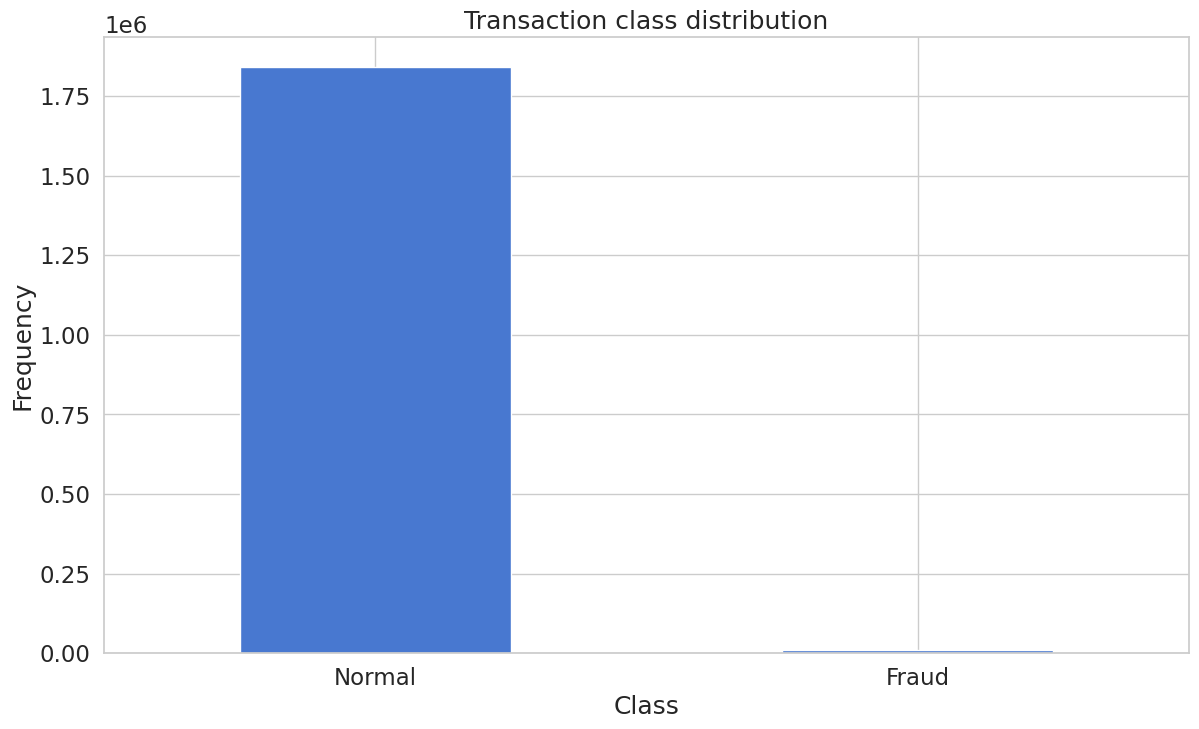

In [17]:
count_classes = pd.value_counts(df['is_fraud'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [18]:
frauds = df[df.is_fraud == 1]
normal = df[df.is_fraud == 0]

In [19]:
frauds.shape

(9651, 11)

In [20]:
normal.shape

(1842743, 11)

In [21]:
frauds.amt.describe()

count    9651.000000
mean      530.163299
std       391.026851
min         1.000000
25%       239.500000
50%       390.000000
75%       902.000000
max      1376.000000
Name: amt, dtype: float64

In [22]:
normal.amt.describe()

count    1.842743e+06
mean     6.715809e+01
std      1.535476e+02
min      1.000000e+00
25%      9.000000e+00
50%      4.700000e+01
75%      8.200000e+01
max      2.894800e+04
Name: amt, dtype: float64

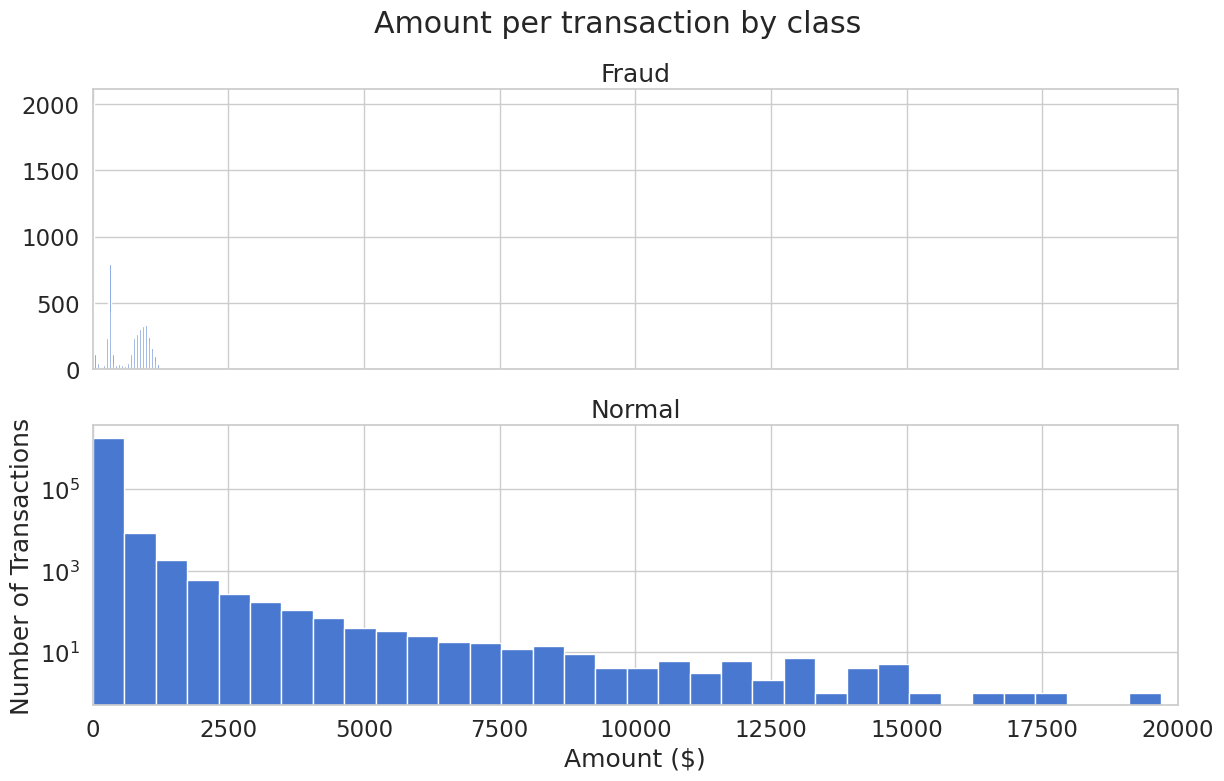

In [23]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.amt, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.amt, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

In [24]:
from sklearn.preprocessing import StandardScaler
data = df
data['amt'] = StandardScaler().fit_transform(data['amt'].values.reshape(-1, 1))

In [25]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.is_fraud == 0]
X_train = X_train.drop(['is_fraud'], axis=1)

y_test = X_test['is_fraud']
X_test = X_test.drop(['is_fraud'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [46]:
X_train.shape

(1474217, 10)

In [47]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [48]:
autoencoder = load_model('/content/drive/MyDrive/CREIDT CARD FRAUD/model.h5')

In [49]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [29]:
nb_epoch = 100
batch_size = 100

autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
14743/14743 [==============================] - 45s 3ms/step - loss: inf - accuracy: 0.0709 - val_loss: inf - val_accuracy: 0.0000e+00
Epoch 2/100
14743/14743 [==============================] - 47s 3ms/step - loss: inf - accuracy: 0.0000e+00 - val_loss: inf - val_accuracy: 0.0000e+00
Epoch 3/100
14743/14743 [==============================] - 43s 3ms/step - loss: inf - accuracy: 0.0000e+00 - val_loss: inf - val_accuracy: 0.0000e+00
Epoch 4/100
14743/14743 [==============================] - 50s 3ms/step - loss: inf - accuracy: 0.0000e+00 - val_loss: inf - val_accuracy: 0.0000e+00
Epoch 5/100
14743/14743 [==============================] - 44s 3ms/step - loss: inf - accuracy: 0.0000e+00 - val_loss: inf - val_accuracy: 0.0000e+00
Epoch 6/100
14743/14743 [==============================] - 42s 3ms/step - loss: inf - accuracy: 0.0000e+00 - val_loss: inf - val_accuracy: 0.0000e+00
Epoch 7/100
14743/14743 [==============================] - 42s 3ms/step - loss: inf - accuracy: 0.0000e+

In [50]:
predictions = autoencoder.predict(X_test)

11578/11578 [==============================] - 17s 1ms/step


In [51]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [52]:
error_df.describe()

reconstruction_error     true_class
count          3.704790e+05  370479.000000
mean           1.889981e+35       0.005272
std            5.993989e+35       0.072414
min            3.651875e+20       0.000000
25%            3.241546e+27       0.000000
50%            1.240038e+30       0.000000
75%            2.148629e+30       0.000000
max            2.492352e+36       1.000000

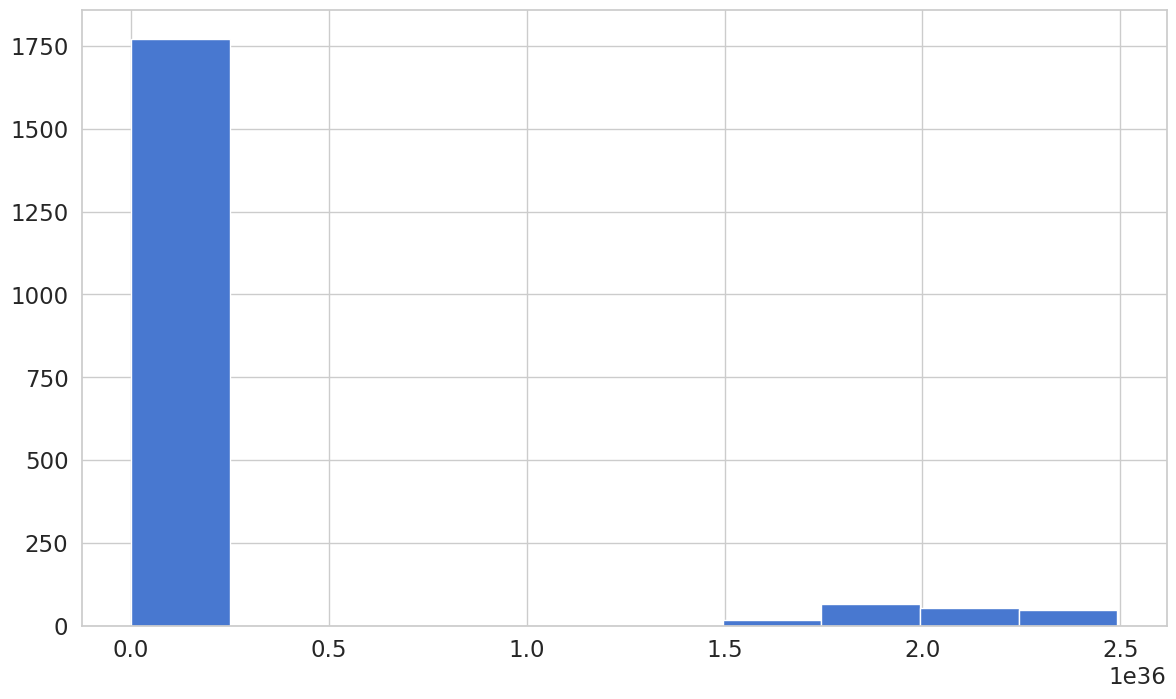

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [55]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

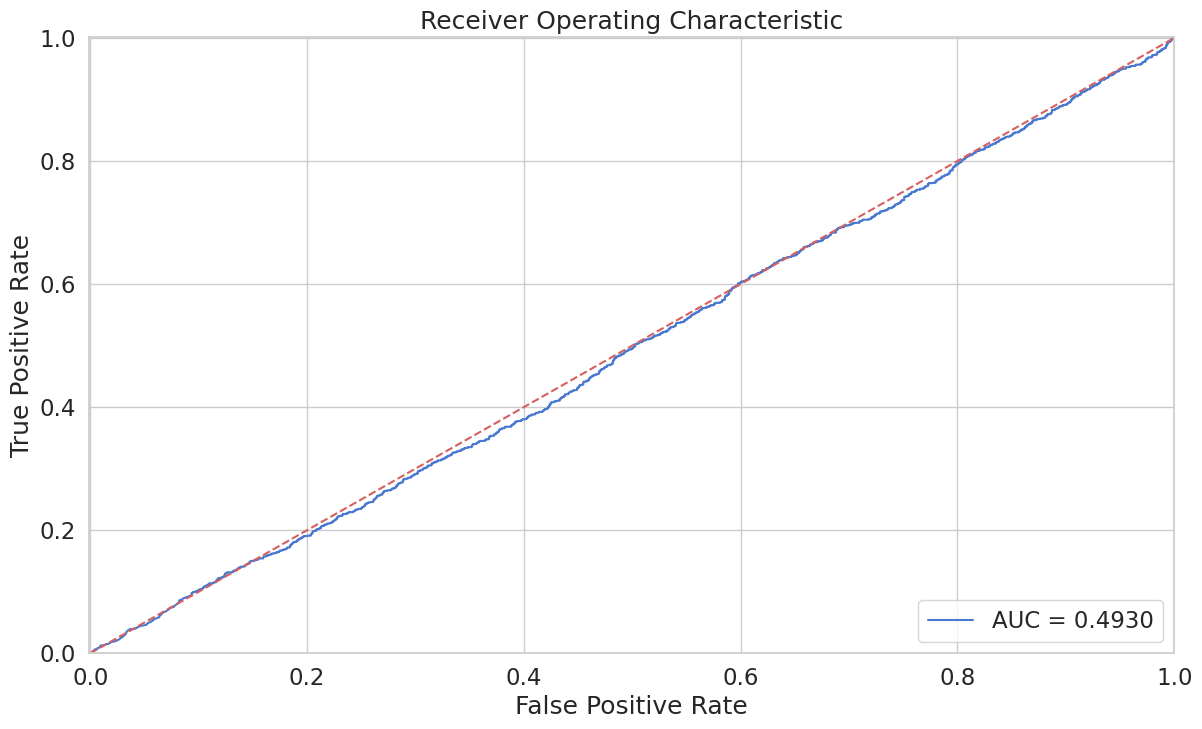

In [56]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

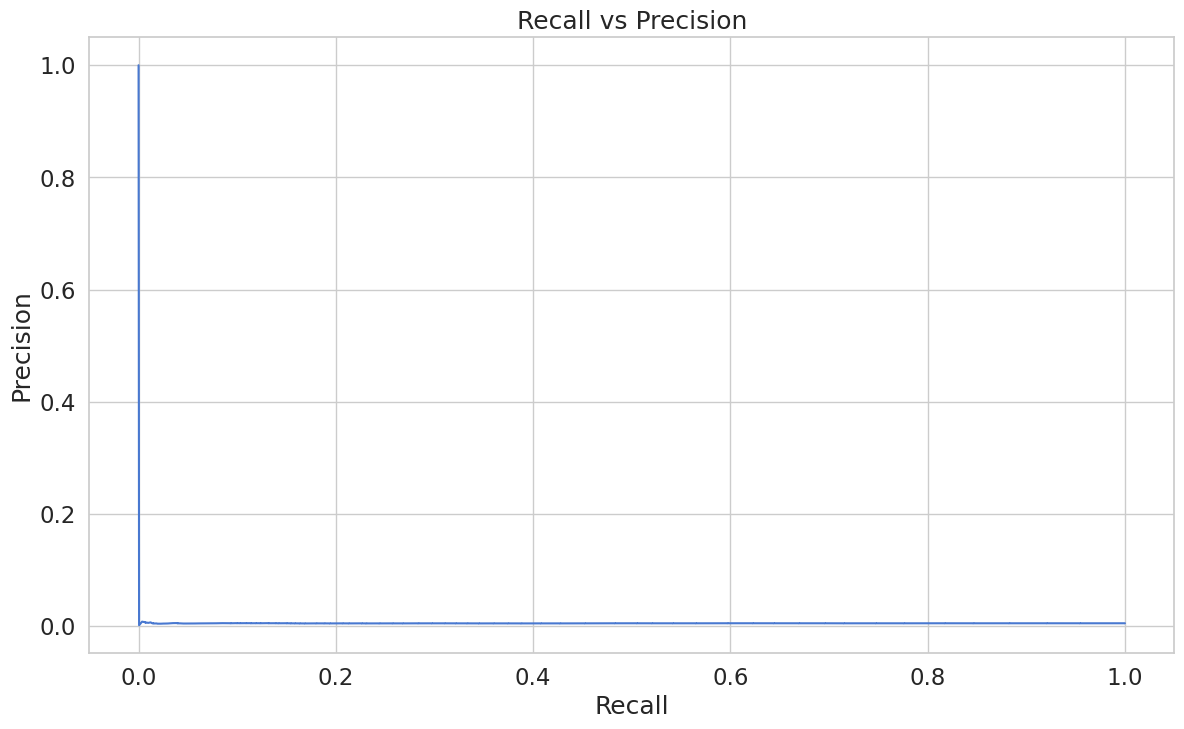

In [57]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

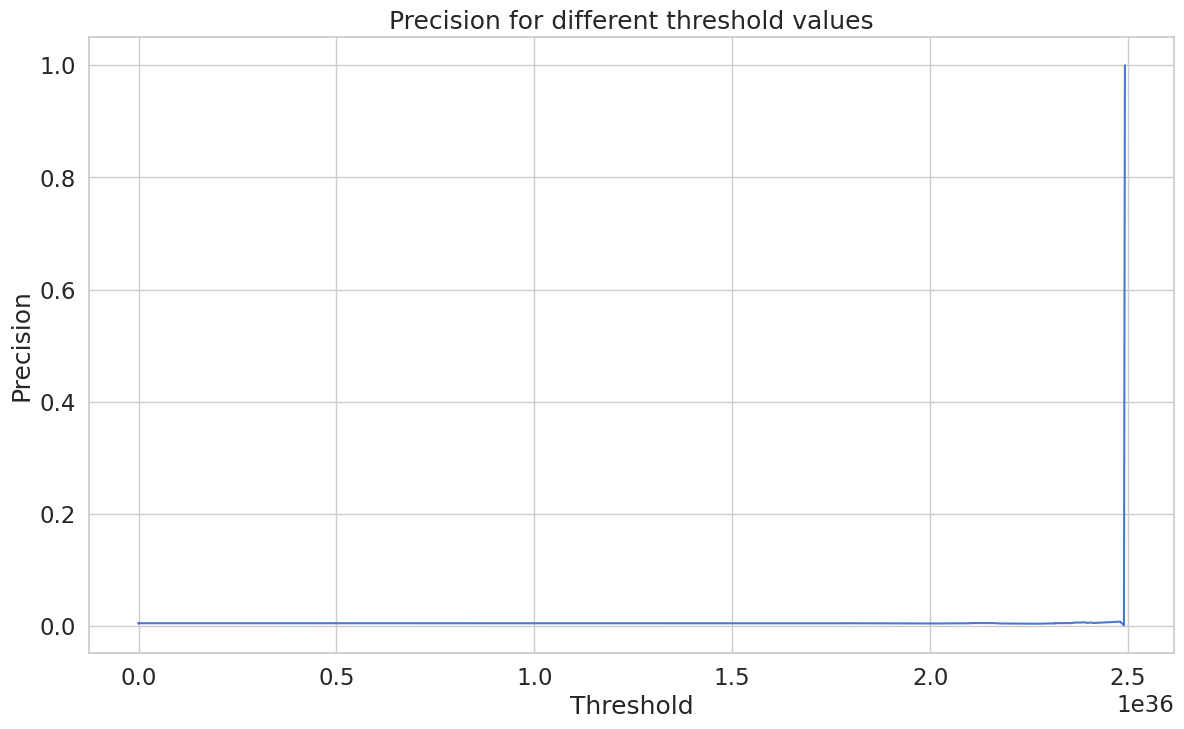

In [58]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

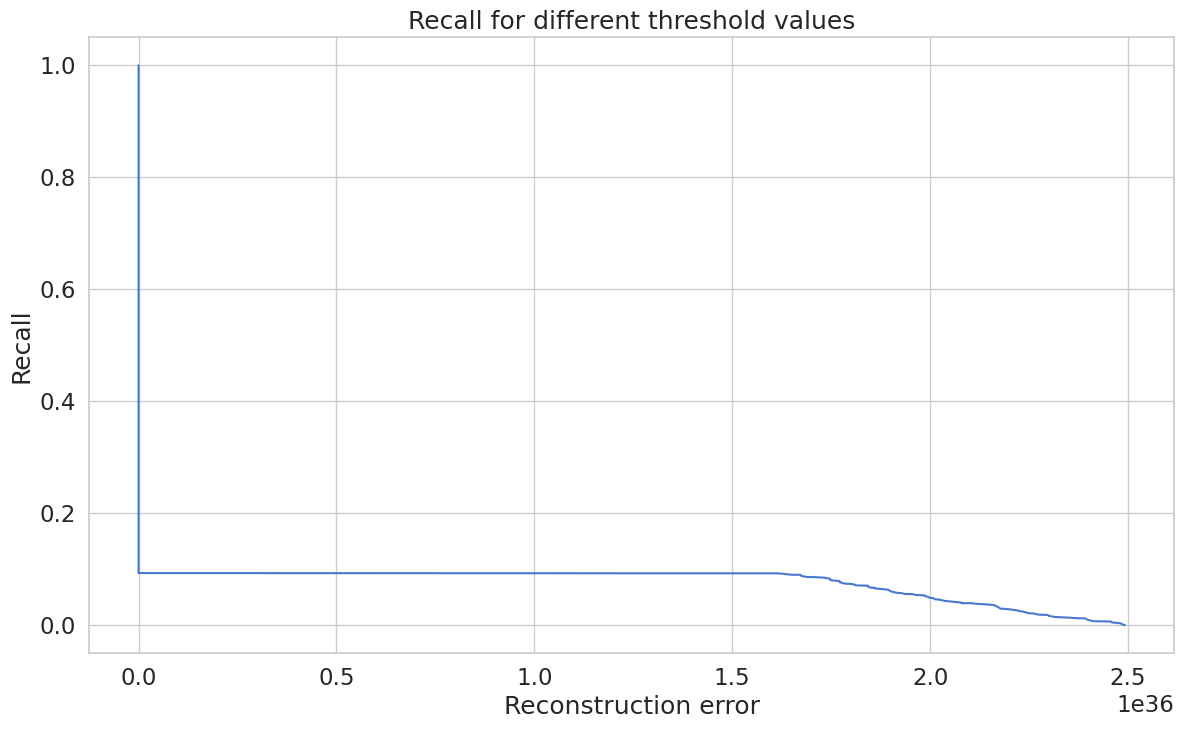

In [59]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [60]:
threshold = 2.9

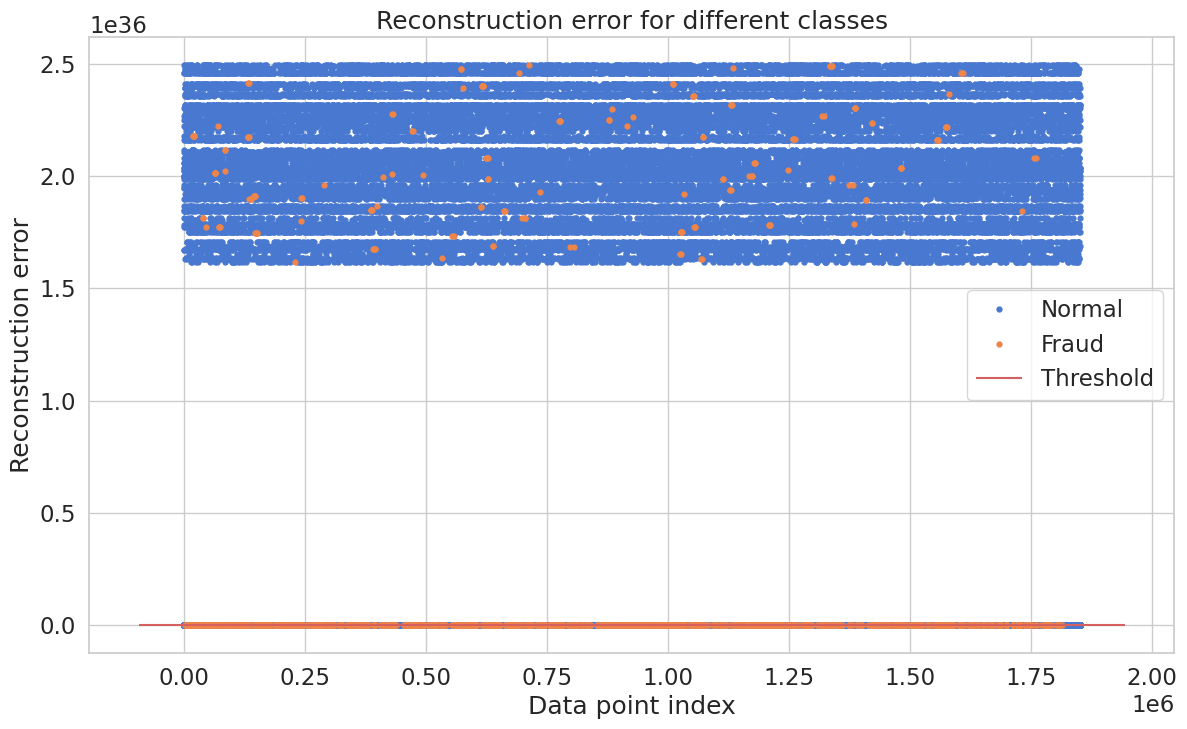

In [61]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

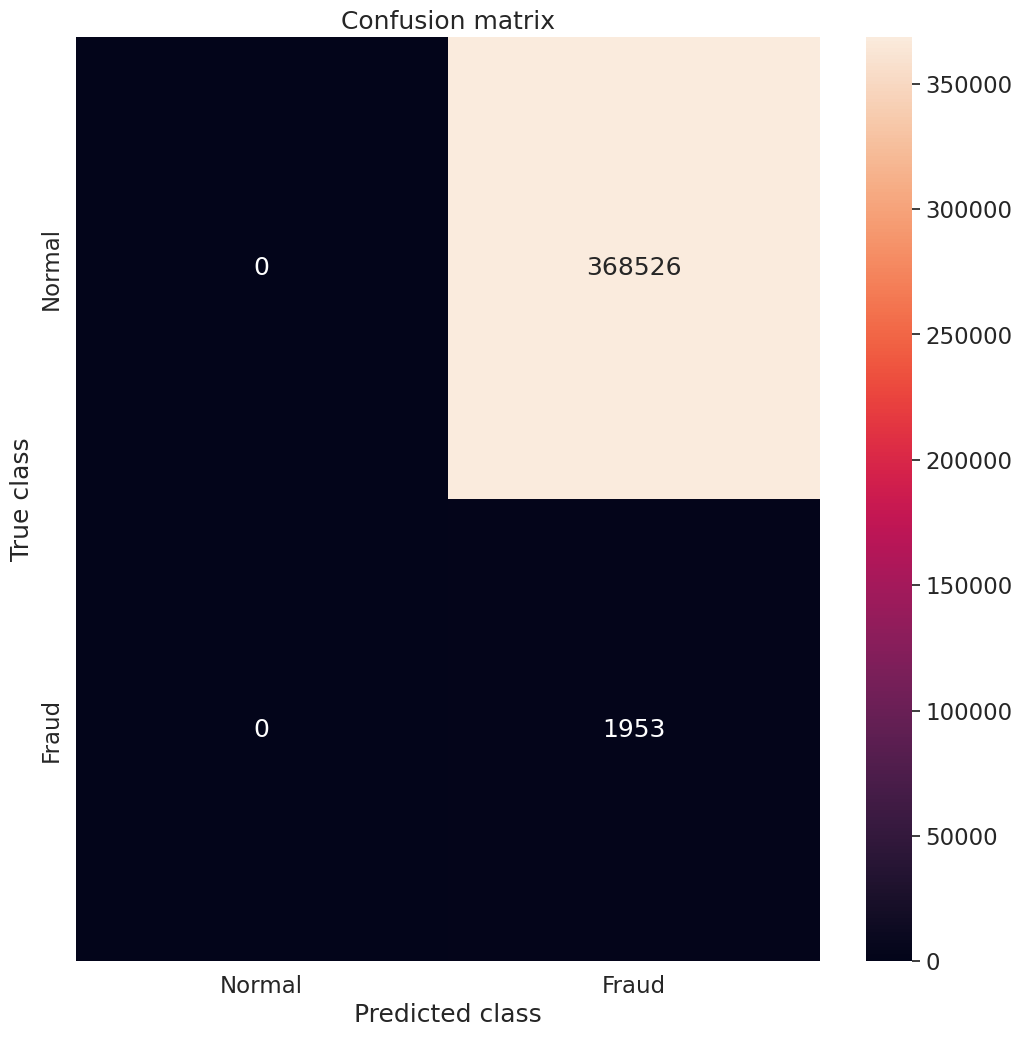

In [62]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()